In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from os import listdir
from os.path import isfile, isdir, join, splitext
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color


In [2]:
# /train/ contains the training set images, named according to subject_imageNum.tif. Every image with the same subject number comes from the same person. This folder also includes binary mask images showing the BP segmentations.
# /test/ contains the test set images, named according to imageNum.tif. You must predict the BP segmentation for these images and are not provided a subject number. There is no overlap between the subjects in the training and test sets.
# train_masks.csv gives the training image masks in run-length encoded format. This is provided as a convenience to demonstrate how to turn image masks into encoded text values for submission.
# sample_submission.csv shows the correct submission file format.
train = pd.read_csv("train_index.csv")
n_train = train.shape[0]

test = pd.read_csv("test_index.csv")
n_test = test.shape[0]

In [3]:
# Debug Sanity check
train.head(3)

,Image,Mask
0,10_100.tif,10_100_mask.tif
1,10_101.tif,10_101_mask.tif
2,10_102.tif,10_102_mask.tif


In [4]:
# Debug Sanity check
test.tail(10)

,Image,Mask
5625,9_91.tif,9_91_mask.tif
5626,9_92.tif,9_92_mask.tif
5627,9_93.tif,9_93_mask.tif
5628,9_94.tif,9_94_mask.tif
5629,9_95.tif,9_95_mask.tif
5630,9_96.tif,9_96_mask.tif
5631,9_97.tif,9_97_mask.tif
5632,9_98.tif,9_98_mask.tif
5633,9_99.tif,9_99_mask.tif
5634,9_9.tif,9_9_mask.tif


In [5]:
ims_train = []
for i in train['Image']:
    a = Image.open('images/train/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_train.append(a)
ims_train = np.array(ims_train)
ims_train = ims_train.reshape(-1, 32,32, 1)
ims_train = ims_train/255
ims_train = np.array( ims_train, dtype=np.float32 )


In [6]:
# Debug
ims_train.shape

(5635, 32, 32, 1)

In [7]:
ms_train = []
for i in train['Mask']:
    a = Image.open('images/train/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_train.append(a)
ms_train = np.array(ms_train)
ms_train = ms_train.reshape(-1, 32,32, 1)
ms_train = ms_train/255
ms_train = np.array(ms_train, dtype=np.float32 )

In [8]:
# Debug
ms_train.shape

(5635, 32, 32, 1)

In [9]:
ims_test = []
for i in test['Image']:
    a = Image.open('images/train/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_test.append(a)
ims_test = np.array(ims_test)
ims_test = ims_test.reshape(-1, 32,32,1)
ims_test = ims_test/255
ims_test = np.array( ims_test, dtype=np.float32 ) 
ims_test.shape

(5635, 32, 32, 1)

In [10]:
ms_test = []
for i in test['Mask']:
    a = Image.open('images/train/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_test.append(a)
ms_test = np.array(ms_test)
ms_test = ms_test.reshape(-1, 32,32,1)
ms_test = ms_test/255
ms_test = np.array(ms_test, dtype=np.float32 ) 
ms_test.shape

(5635, 32, 32, 1)

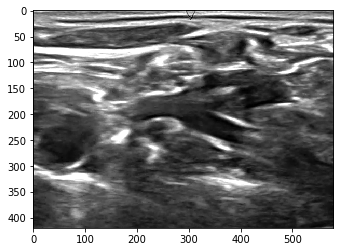

In [18]:
img = Image.open('images/train/1_106.tif')
plt.imshow(img, cmap='gist_gray')

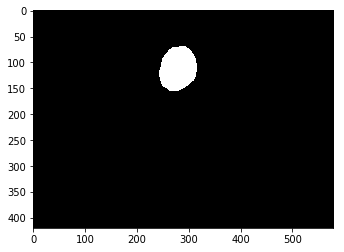

In [12]:
img = Image.open('images/train/1_106_mask.tif')
plt.imshow(img, cmap='gist_gray')

In [13]:
x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

In [14]:
hold_prob = tf.placeholder(tf.float32)

In [15]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def shufled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [16]:
def upsampling_2D(tensor,  size=(2, 2)):
    """Upsample/Rescale `tensor` by size
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        name (str): name of upsampling operations
        size (tuple, optional): (height_multiplier, width_multiplier)
            (default: (2, 2))
    Returns:
        output (4-D Tensor): (N, h_multiplier * H, w_multiplier * W, C)
    """
    H, W, _ = tensor.get_shape().as_list()[1:]

    H_multi, W_multi = size
    target_H = H * H_multi
    target_W = W * W_multi

    return tf.image.resize_nearest_neighbor(tensor, (target_H, target_W))

In [17]:
def upsample_concat(inputA, input_B):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    upsample = upsampling_2D(inputA, size=(2, 2))

    return tf.concat([upsample, input_B], axis=-1)

In [ ]:
# taken form  https://github.com/kkweon/UNet-in-Tensorflow/blob/master/train.py 
# but I renabed it from UIO_ into "dice_score" since 
# it return the value 2 * area of overlap / (area of overlap + area of union)
# but IOU is area of overlap / area of union
# IoU metric tends to penalize single instances of bad classification more than the dice score
def dice_score(y_pred, y_true): # same as F1 score
    """Returns a dice score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)

In [ ]:
# Creating layers
convo_1 = convolutional_layer(x,shape=[3,3,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [ ]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,32,64]) # images 16*16
#convo_2_pooling = max_pool_2by2(convo_2)

In [ ]:
up_1 = upsample_concat(convo_2, convo_1) # image 32*32
convo_3 = convolutional_layer(up_1,shape=[3,3,96,32])

In [ ]:
# training prediction
pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

In [ ]:
loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.001)
train = optim.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(1500):
        #offset = (i * 100) % (ims_train.shape[0] - 100) # 100 is the batch size
        #batch_x = ims_train[offset:(offset + 100), :]
        #batch_y = ms_train[offset:(offset + 100), :]
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
test_result = output >= 0.5

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(test_result[3].reshape(32, 32),cmap='gist_gray')
axes[0].set_title('Predicte Mask')

axes[1].imshow(ms_test[3].reshape(32, 32),cmap='gist_gray')
axes[1].set_title('True Mask')

In [ ]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

In [ ]:
# CNN with 2+ layers


x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
convo_1_2 = convolutional_layer(convo_1,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,16,32]) # images 16*16

up_1 = upsample_concat(convo_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
convo_3 = convolutional_layer(convo_3_0,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.001)
train = optim.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(1500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
test_result = output >= 0.5

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(test_result[3].reshape(32, 32),cmap='gist_gray')
axes[0].set_title('Predicte Mask')

axes[1].imshow(ms_test[3].reshape(32, 32),cmap='gist_gray')
axes[1].set_title('True Mask')

In [ ]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

In [ ]:
# Add optimization DROPOUT to avoid overfitting

hold_prob = tf.placeholder(tf.float32)

x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
dropout_0 = tf.nn.dropout(convo_1,keep_prob=hold_prob)
convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)
convo_3 = convolutional_layer(dropout_3,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
test_result = output >= 0.5  # predicted masks

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

In [ ]:
# Use Higher-resol images

train = pd.read_csv("tr_data.csv")
n_train = train.shape[0]

test = pd.read_csv("test_data.csv")
n_test = test.shape[0]

ims_train = []
for i in train['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ims_train.append(a)
ims_train = np.array(ims_train)
ims_train = ims_train.reshape(-1, 64,64, 1)
ims_train = ims_train/255
ims_train = np.array( ims_train, dtype=np.float32 ) 

ms_train = []
for i in train['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ms_train.append(a)
ms_train = np.array(ms_train)
ms_train = ms_train.reshape(-1, 64,64, 1)
ms_train = ms_train/255
ms_train = np.array(ms_train, dtype=np.float32 )

In [ ]:
plt.imshow(ims_train[1].reshape(64,64),cmap='gist_gray')

In [ ]:
ims_test = []
for i in test['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ims_test.append(a)
ims_test = np.array(ims_test)
ims_test = ims_test.reshape(-1, 64,64,1)
ims_test = ims_test/255
ims_test = np.array( ims_test, dtype=np.float32 ) 
ims_test.shape

ms_test = []
for i in test['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ms_test.append(a)
ms_test = np.array(ms_test)
ms_test = ms_test.reshape(-1, 64,64,1)
ms_test = ms_test/255
ms_test = np.array(ms_test, dtype=np.float32 ) 
ms_test.shape

In [ ]:
x = tf.placeholder(tf.float32,shape=[None,64,64,1])
y = tf.placeholder(tf.float32, shape=[None, 64,64, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
convo_1_0_pooling = max_pool_2by2(convo_1)
dropout_0 = tf.nn.dropout(convo_1_0_pooling,keep_prob=hold_prob)

convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)

up_2 = upsample_concat(dropout_3, convo_1) # image 32*32
convo_3 = convolutional_layer(up_2,shape=[3,3,32,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
print('Final test loss: ', final_test_loss)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
test_result = output >= 0.5  # predicted masks

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(64,64),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(64,64),cmap='gist_gray')
    axes[1].set_title('True Mask')

In [ ]:
x = tf.placeholder(tf.float32,shape=[None,64,64,1])
y = tf.placeholder(tf.float32, shape=[None, 64,64, 1])

convo_0 = convolutional_layer(x,shape=[3,3,1,16])
convo_1 = convolutional_layer(convo_0,shape=[3,3,16,16])
convo_1_0_pooling = max_pool_2by2(convo_1)
dropout_0 = tf.nn.dropout(convo_1_0_pooling,keep_prob=hold_prob)

convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)

up_2 = upsample_concat(dropout_3, convo_1) # image 32*32
convo_3 = convolutional_layer(up_2,shape=[3,3,32,16])
convo_4 = convolutional_layer(convo_3,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
print('Final test loss: ', final_test_loss)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
test_result = output >= 0.5  # predicted masks
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(64,64),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(64,64),cmap='gist_gray')
    axes[1].set_title('True Mask')